# 0.0 Imports

In [79]:
import numpy as np
import pandas as pd
import psycopg2 as pg
import sweetviz as sv
import seaborn as sns
import scikitplot as skplt

from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# 0.1 Load Dataset

In [80]:
# Credentials

host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd =' cdspa'

# Connection with Database
conn_string = f'host={host} port={port} dbname={database} user={username} password={pwd}'
conn = pg.connect(conn_string)

# SQL Query
query = '''
    select * 
    from pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                       LEFT JOIN pa004.insurance i ON (u.id = i.id)
'''

df = pd.read_sql(query, conn)
conn.close()
df.head()

C:\Users\Notebook\anaconda3\envs\insurance-cross-sell-env\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [81]:
print('Rows: {}'.format(df.shape[0]))
print('Columns: {}'.format(df.shape[1]))

Rows: 381109
Columns: 14


In [82]:
df_raw = df.loc[:,~df.columns.duplicated()]
df_raw.sample(3)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
264717,210294,Male,26,8.0,152.0,1,< 1 Year,No,1,2630.0,19,0
91301,347261,Female,23,37.0,151.0,1,< 1 Year,Yes,0,32941.0,159,0
152571,76336,Male,26,28.0,152.0,1,< 1 Year,No,1,40752.0,81,0


In [83]:
print('Rows: {}'.format(df_raw.shape[0]))
print('Columns: {}'.format(df_raw.shape[1]))

Rows: 381109
Columns: 12


# 1.0 Data Description

In [84]:
df1 = df_raw.copy()

## 1.1 Data Dimension

In [85]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## 1.2 Data Types

In [86]:
for att in df1.columns:
    print(att, '({}) : '.format(df1[att].dtype), df1[att].unique(), "\n")

id (int64) :  [     7     13     18 ... 381082 381097 381100] 

gender (object) :  ['Male' 'Female'] 

age (int64) :  [23 41 25 26 45 44 29 31 50 49 59 20 24 22 52 60 55 40 64 69 58 78 34 75
 37 54 46 42 51 76 57 27 38 21 71 77 33 47 72 28 43 39 53 68 62 56 36 35
 30 61 63 66 74 67 32 70 73 48 65 80 79 81 82 84 85 83] 

region_code (float64) :  [11. 15. 35.  8. 28. 39. 29. 30. 25. 22. 36.  0. 26.  6. 48. 47. 33. 41.
 46. 43.  2. 37. 40.  4. 10. 18.  9.  3. 50. 32. 24. 27. 34. 21. 45. 12.
  5. 49. 14. 16. 13. 31. 23.  1. 42.  7. 17. 44. 19. 38. 20. 52. 51.] 

policy_sales_channel (float64) :  [152.  14. 160. 124.  13.  26. 151. 157. 156. 122.  23.  11. 163.  12.
 154.  31.  19. 120.  55.  56.  24.   8.  10.   9.  61.  29.  52.  22.
 150. 147.  15. 155.  60.   7. 125.  30.  18.  25. 145. 158. 139. 135.
 136. 131.   3.   1. 127. 105.  16. 140.  91. 128. 113.  94. 132.  54.
  42. 103. 153.   4.  51. 116.  36. 107. 146. 108.  47. 138. 111.  35.
 114.  45.  86. 121. 123. 109.  59. 119.  37. 

## 1.3 Check NA

In [87]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Data Descriptive

In [88]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### 1.4.1 Numerical atributes

In [89]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','median','std','skew','kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.000000,110016.691870,-8.071174e-18,-1.200000
1,age,20.0,85.0,65.0,38.822584,38.822584,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,26.388807,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,112.034295,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,0.997869,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.458210,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,30564.389581,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.347397,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.122563,0.327935,2.301906e+00,3.298788


# 2.0 Feature Engineering

In [90]:
df2 = df1.copy()

In [91]:
df2['vehicle_age'].unique()

array(['< 1 Year', '1-2 Year', '> 2 Years'], dtype=object)

In [92]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


In [93]:
# vericle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'bellow_1_year' if x == '< 1 Year' else 
                                                     'between_1_2_year' if x == '1-2 Year' else 
                                                     'over_2_years')
df2['vehicle_damage'] = df2['vehicle_damage'].map({'Yes':1,'No':0}) 

In [94]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,bellow_1_year,1,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,between_1_2_year,0,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,bellow_1_year,0,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,bellow_1_year,0,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,between_1_2_year,1,0,42297.0,264,0


# 3.0 Data Filtering

In [95]:
df3 = df2.copy()

# 4.0 Exploratory Data Analysis

In [96]:
df4 = df3.copy()

In [97]:
# report = sv.analyze(df4)
# report.show_html()

### 4.1. Univariate Analysis

In [98]:
# 'gender'

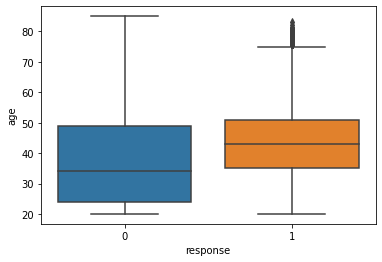

In [99]:
# 'age'
sns.boxplot(x='response',y='age',data=df4);

#### Interesed

#### Not interessed

<AxesSubplot:xlabel='age', ylabel='Count'>

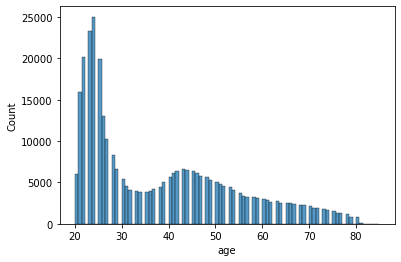

In [100]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

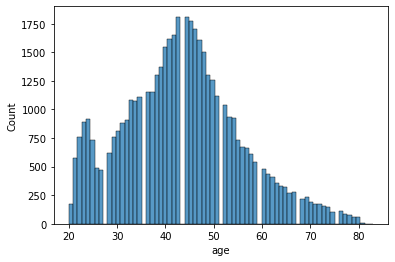

In [101]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux00)

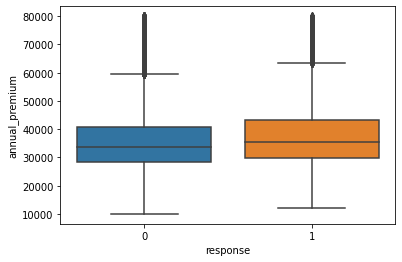

In [102]:
# 'annual_premium'
aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response',y='annual_premium',data=aux);

#### Interesed

#### Not interessed

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

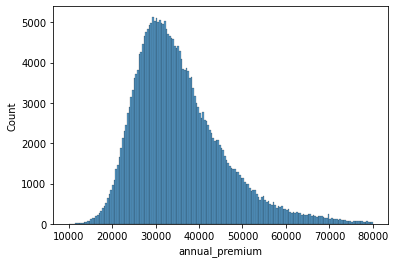

In [103]:
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

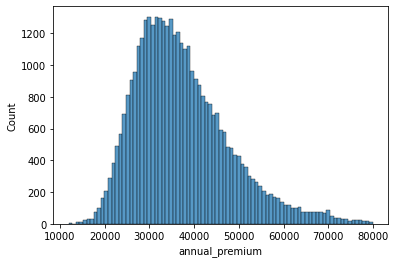

In [104]:
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux00)

In [105]:
# 'driving_license'
aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license']/aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


In [106]:
# 'region_code'
aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()

<AxesSubplot:xlabel='region_code', ylabel='id'>

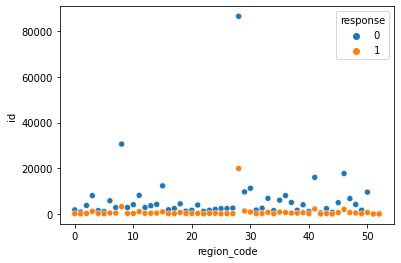

In [107]:
sns.scatterplot(x='region_code', y= 'id', hue = 'response', data=aux0)

<AxesSubplot:xlabel='region_code'>

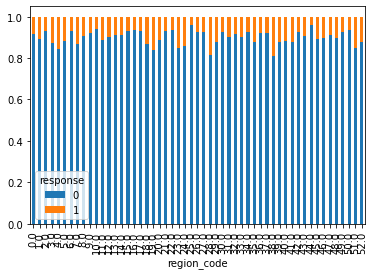

In [108]:
df_grouped = df4[["region_code", "response"]].groupby('region_code').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True)

In [109]:
# 'previously_insured'
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


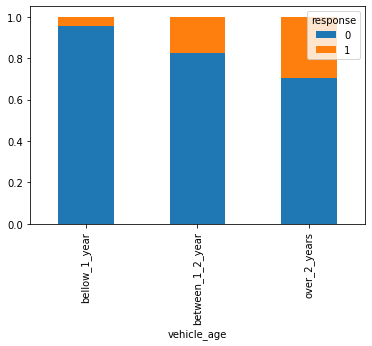

In [110]:
# 'vehicle_age'
df_grouped = df4[["vehicle_age", "response"]].groupby('vehicle_age').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True);

In [111]:
# policy_sales_channel
aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
aux1 = aux0[aux0['response'] > 40.0]

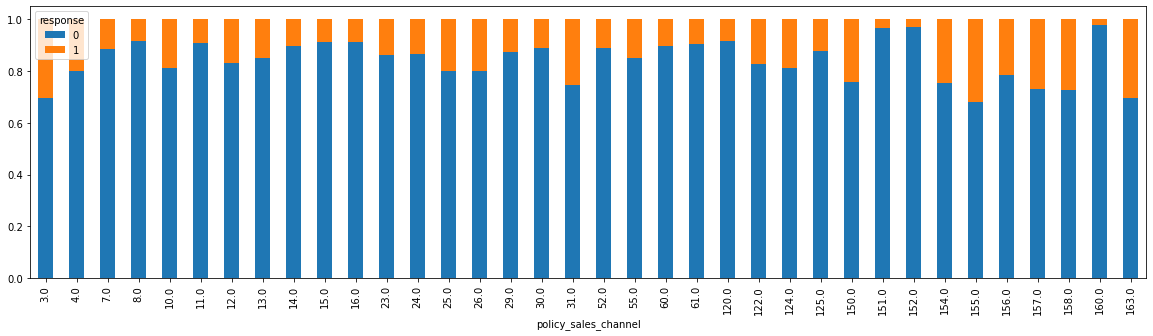

In [112]:
# 'policy_sales_channel'
aux2 = df4[df4['policy_sales_channel'].isin(aux1['policy_sales_channel'])]
df_grouped = aux2[["policy_sales_channel", "response"]].groupby('policy_sales_channel').value_counts(normalize=True).unstack('response')
df_grouped.plot.bar(stacked=True,figsize=(20,5));

<AxesSubplot:xlabel='policy_sales_channel', ylabel='response'>

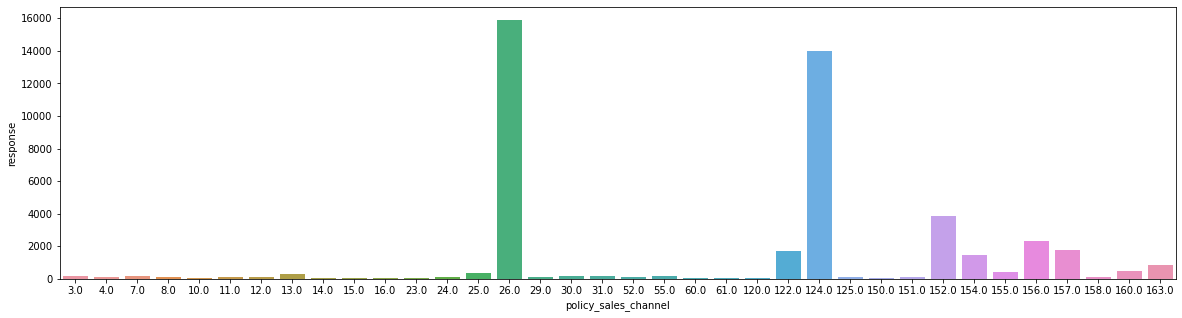

In [113]:
fig = plt.figure(figsize=(20,5))
aux = df4[["policy_sales_channel", "response"]].groupby('policy_sales_channel').sum().reset_index()
aux = aux[aux['response'] > 40]

sns.barplot(data=aux,x='policy_sales_channel',y='response')

In [114]:
# 'vehicle_damage'

In [115]:
# 'vintage'

<AxesSubplot:xlabel='vintage', ylabel='Count'>

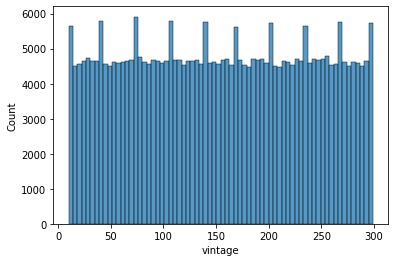

In [116]:
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

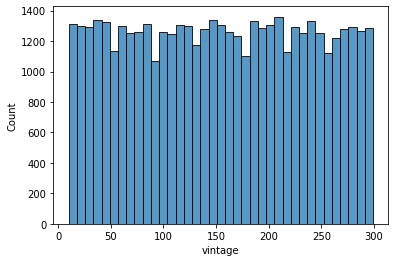

In [117]:
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux00)

In [118]:
# 'response'


# 5.0 Data Preparation

In [119]:
df5 = df4.copy()

In [120]:
X = df4.drop('response',axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [121]:
ss = pp.StandardScaler()

## annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [122]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

## age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

## vintage
df5['vintage'] = mms_age.fit_transform( df5[['vintage']].values )

## 5.3 Encoder

In [123]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)

## region_code - Frequency Enconding / Target Enconding / Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:,'region_code'] = df5['region_code'].map(target_encode_region_code)

## vehicle_age - One Hot Enconding / Ordinal Enconding / Frequency Enconding
df5 = pd.get_dummies(df5, prefix='vehicle_age',columns=['vehicle_age'])

## vehicle_damage

## policy_sales_channel - Target Enconding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

In [124]:
x_val

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
334464,0.826990,2.771576,0.390625,0.187129,1,0.194659,0
51509,0.858131,0.628871,0.015625,0.123497,0,0.209251,1
237837,0.584775,0.878554,0.062500,0.095100,0,0.353656,1
152925,0.134948,0.458324,0.093750,0.187129,0,0.353656,1
17554,0.671280,0.011735,0.453125,0.103662,1,0.194659,0
...,...,...,...,...,...,...,...
325065,0.190311,0.158318,0.078125,0.125034,0,0.056844,1
173982,0.986159,-0.180846,0.296875,0.123061,1,0.003227,0
228559,0.508651,2.050990,0.265625,0.095100,1,0.209251,0
9950,0.245675,0.071058,0.078125,0.058076,0,0.353656,1


## 5.4 Validation Preparation

In [125]:
# gender
x_validation.loc[:,'gender'] = x_validation.loc[:,'gender'].map(target_encode_gender)

x_validation.loc[:,'annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# age
x_validation.loc[:,'age'] = mms_age.fit_transform(x_validation[['age']].values)

# region_code
x_validation.loc[:,'region_code'] = x_validation.loc[:,'region_code'].map(target_encode_region_code)

# vehicle_damage
x_validation = pd.get_dummies(x_validation, prefix = 'vehicle_age',columns=['vehicle_age'])

# annual_premium
x_validation.loc[:,'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

In [126]:
x_validation

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_bellow_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
264438,208204,0.103980,0.292308,0.185607,0.209287,1,1,0,0.383560,0.903114,0,1,0
50070,18195,0.103980,0.430769,0.185607,0.194420,1,1,0,0.228267,0.027682,0,1,0
378019,356547,0.137477,0.092308,0.074353,0.353288,1,0,1,-0.015524,0.467128,1,0,0
33858,270446,0.137477,0.384615,0.123989,0.002201,1,0,1,1.559925,0.051903,0,1,0
352041,148469,0.103980,0.061538,0.102741,0.015760,1,1,0,-1.625651,0.006920,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243549,40521,0.137477,0.400000,0.123989,0.209287,1,1,0,-0.211779,0.570934,0,1,0
146564,29098,0.103980,0.615385,0.185607,0.026095,1,0,1,1.194820,0.892734,0,1,0
213469,180504,0.137477,0.492308,0.069391,0.209287,1,0,1,-0.191066,0.557093,0,1,0
199671,69869,0.137477,0.015385,0.078498,0.353288,1,0,1,-1.625651,0.934256,1,0,0


# 6.0 Feature Selection

## 6.1 Feature Importance

In [127]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n.columns, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j},index=[0])
    df= pd.concat([df, aux], axis=0)

df

Feature ranking


,feature,importance
0,gender,0.004943
0,age,0.164710
0,region_code,0.106196
0,policy_sales_channel,0.059038
0,driving_license,0.000471
0,vehicle_damage,0.067602
0,previously_insured,0.056172
0,annual_premium,0.245011
0,vintage,0.273074
0,vehicle_age_bellow_1_year,0.014099


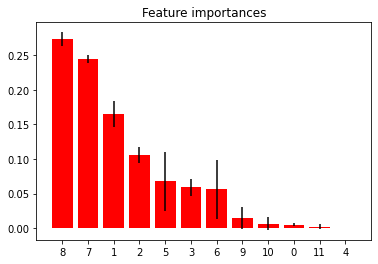

In [128]:
# plot the impurity-based feature importance of the forest

plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_n.shape[1]),importances[indices], color='r', yerr=std[indices], align = 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning

In [129]:
cols_selected = ['vintage',
                'annual_premium',
                'age',
                'region_code',
                'vehicle_damage',
                'policy_sales_channel',
                'previously_insured']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]

In [130]:
x_val

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
264438,0.903114,0.383560,0.292308,0.185607,1,0.209287,0
50070,0.027682,0.228267,0.430769,0.185607,1,0.194420,0
378019,0.467128,-0.015524,0.092308,0.074353,0,0.353288,1
33858,0.051903,1.559925,0.384615,0.123989,0,0.002201,1
352041,0.006920,-1.625651,0.061538,0.102741,1,0.015760,0
...,...,...,...,...,...,...,...
243549,0.570934,-0.211779,0.400000,0.123989,1,0.209287,0
146564,0.892734,1.194820,0.615385,0.185607,0,0.026095,1
213469,0.557093,-0.191066,0.492308,0.069391,0,0.209287,1
199671,0.934256,-1.625651,0.015385,0.078498,0,0.353288,1


## 7.1 KNN

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

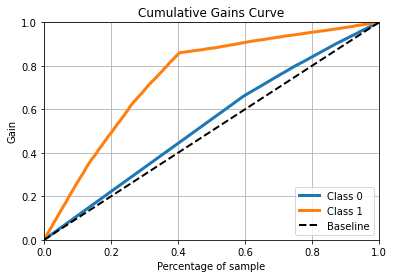

In [131]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model predi
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_knn)

## 7.2 Logistic Regressor

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

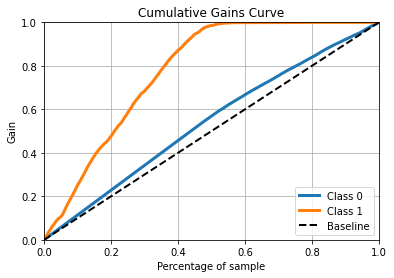

In [132]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training 
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr)

## 7.3 Extra Trees

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

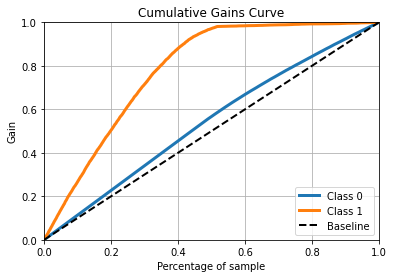

In [133]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model fit
et.fit(x_train, y_train)

# model predict
yhat_et = et.predict_proba(x_val)

# Accumulative Gain 
skplt.metrics.plot_cumulative_gain(y_validation,yhat_et)

# 8.0 Model Performance

In [155]:
def precision_at_k(data, k=2000):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k,'precision_at_k']

def recall_at_k(data, k=2000):

    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k,'recall_at_k']

In [156]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# Propensity score
df8['score'] = yhat_knn[:,1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score',ascending=False)

# compute precision at k
print('Precision at K: {}'.format(precision_at_k(df8,k=50)))
print('Recall at K: {}'.format(recall_at_k(df8,k=50)))

Precision at K: 0.3137254901960784
Recall at K: 0.0016877637130801688
